Notebook to analyse test performances, including :
- full-disk level performances
- patch/sector level performances
- center vs. limb pathes performances
- performances on windows where the activity differes from the previous one (AC-windows)
- performances on windows where the activity is the same as the previous one (NC-windows)
- persistent relative metrics

# Libraries

In [1]:
from config import * # notebooks config files -> retrieve path to sundl + PATHS constants

from pathlib import Path
from glob import glob
import dill as pickle

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sundl.utils.data import read_Dataframe_With_Dates

if COLAB:
  # mouting drive content in session on colab
  mountDrive()

2024-01-23 14:36:31.904008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [2]:
FOLDER = PATH_RES/'Results_Paper_PCNN' 

modelDict = {
  'C+_mpf_Persistant_24'                                    : 'C+_Persistant',
  'C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24'           : 'C+_SPCNN_Blos',
  'C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24' : 'C+_SPCNN_EUV',
  'M+_mpf_Persistant_24'                                    : 'M+_Persistant',
  'M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24'              : 'M+_SPCNN_Blos',
  'M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x0211x0094_24' : 'M+_SPCNN_EUV',
  'C+_SPCNN_Both_Max'                                       : 'C+_SPCNN_Both_Max',
  'M+_SPCNN_Both_Max'                                       : 'M+_SPCNN_Both_Max', 
  'C+_SPCNN_Both_Avg'                                       : 'C+_SPCNN_Both_Avg',
  'M+_SPCNN_Both_Avg'                                       : 'M+_SPCNN_Both_Avg' 
}

modelDictRev = {modelDict[oldName] : oldName for oldName in modelDict.keys()}

sns.set(style="whitegrid")

# Full Disk Performances

## Load predictions

In [3]:
fdPredictions = {}
for modelNameFull in modelDict.keys():
  modelName = modelNameFull # modelDict[modelNameFull]
  pathPredFd_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', True)
  if pathPredFd_withLabels.exists():
    fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd_withLabels)
  else:
    pathPredFd = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', False)
    if pathPredFd.exists():
      fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd)
      fdPredictions[modelName]['histo'] = fdPredictions[modelName]['label'].rolling(window = f'{24}H',
                                        closed = 'right', # min_periods = int(input_lag)
                                        ).apply(
                                          lambda x: x[0])
      fdPredictions[modelName]['change'] = fdPredictions[modelName]['histo'] != fdPredictions[modelName]['label']
      fdPredictions[modelName].to_csv(pathPredFd_withLabels)

## Compute Performances

In [4]:
from notebooks.flare_limits_pcnn.utilsTest import fullDiskPerformance

startingDates = pd.date_range(start = datetime.datetime(2020,1,1), end = datetime.datetime(2023,1,1), freq = '31D').to_pydatetime().tolist()
filterNames   = ['all','windowChanging', 'windowConstant']
includeFolds  = True

perfTest = fullDiskPerformance(fdPredictions, 
                               startingDates, 
                               filterNames, 
                               includeFolds)

/Users/greg/Projects/sundl/notebooks/flare_limits_pcnn/../../notebooks/flare_limits_pcnn/utilsTest.py:141: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTest = pd.concat([perfTest,pd.DataFrame({
/Users/greg/Projects/sundl/notebooks/flare_limits_pcnn/../../notebooks/flare_limits_pcnn/utilsTest.py:126: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/Projects/sundl/notebooks/flare_limits_pcnn/../../notebooks/flare_limits_pcnn/utilsTest.py:126: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)


### Standard Metrics

In [5]:
viz = perfTest.copy()[perfTest.modelFdId == 'avg']
viz = viz[viz['startingDate']==viz['startingDate'].min()]

col = ['model', 'filter','tss', 'hss', 'f1', # 'modelFdId', 'group', 'thd'
       'recall', 'far', 'mcc', 'acc_w', 'fssp', 'fssr', 'bal_pos', 'switch_rate'
]
viz[viz['filter']=='all'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
1,C+_mpf_Persistant_24,all,0.749021,0.749082,0.867786,0.867087,0.131513,0.749083,0.874511,-0.000123,0.742590,0.473461,0.125095
8,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,all,0.714355,0.717545,0.845086,0.808400,0.114741,0.720014,0.857177,-0.026218,0.698534,0.473008,0.125026
38,C+_SPCNN_Both_Avg,all,0.712068,0.712707,0.849559,0.821707,0.120634,0.714205,0.856034,-0.022722,0.701205,0.493062,0.128875
27,C+_SPCNN_Both_Max,all,0.701708,0.701215,0.852222,0.874102,0.168589,0.702115,0.850854,-0.019658,0.706495,0.493062,0.128875
2,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,all,0.653117,0.653512,0.820427,0.801609,0.159850,0.654184,0.826558,-0.056629,0.643255,0.493314,0.128582
14,M+_mpf_Persistant_24,all,0.493066,0.493066,0.560912,0.560912,0.439088,0.493066,0.746533,0.000000,0.443380,0.133838,0.117533
21,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,all,0.605453,0.436022,0.535297,0.781332,0.592896,0.471837,0.802726,-0.041941,0.410876,0.133872,0.118147
43,M+_SPCNN_Both_Avg,all,0.612651,0.413949,0.526157,0.827985,0.614405,0.463758,0.806325,-0.059939,0.393182,0.140316,0.123561
15,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,all,0.554257,0.372055,0.492911,0.781495,0.640019,0.418358,0.777129,-0.121212,0.350360,0.140558,0.123439
32,M+_SPCNN_Both_Max,all,0.602135,0.367792,0.494848,0.871647,0.654504,0.437319,0.801068,-0.115877,0.353087,0.140316,0.123561


### AC - metrics

In [6]:
viz[viz['filter']=='windowChanging'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
63,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,windowChanging,0.009634,0.009622,0.579929,0.686977,0.498255,0.010345,0.504817,0.581430,0.161359,0.498214,1.0
80,M+_SPCNN_Both_Max,windowChanging,-0.016978,-0.016921,0.600187,0.770433,0.508436,-0.020458,0.491511,0.602576,0.202763,0.497013,1.0
75,C+_SPCNN_Both_Max,windowChanging,-0.022326,-0.022337,0.508269,0.523864,0.506424,-0.022380,0.488837,0.504326,0.012595,0.504009,1.0
91,M+_SPCNN_Both_Avg,windowChanging,-0.028466,-0.028392,0.575504,0.703125,0.512906,-0.031612,0.485767,0.578040,0.153544,0.497013,1.0
56,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowChanging,-0.041491,-0.041418,0.394788,0.338170,0.525822,-0.043251,0.479254,0.391050,-0.212847,0.503088,1.0
86,C+_SPCNN_Both_Avg,windowChanging,-0.054469,-0.054375,0.413486,0.369318,0.530347,-0.055677,0.472765,0.408783,-0.176317,0.504009,1.0
69,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowChanging,-0.058339,-0.058240,0.540680,0.627240,0.524887,-0.061427,0.470830,0.543136,0.083816,0.497326,1.0
50,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,windowChanging,-0.058828,-0.058790,0.447886,0.426788,0.528822,-0.059056,0.470586,0.444100,-0.107279,0.503429,1.0
49,C+_mpf_Persistant_24,windowChanging,-1.000000,-0.999926,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.503050,1.0
62,M+_mpf_Persistant_24,windowChanging,-1.000000,-1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.500000,1.0


### NC - metrics

In [7]:
viz[viz['filter']=='windowConstant'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
97,C+_mpf_Persistant_24,windowConstant,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.469231,0.0
110,M+_mpf_Persistant_24,windowConstant,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.085070,0.0
104,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowConstant,0.824646,0.827382,0.905953,0.880520,0.067102,0.828547,0.912323,-0.094047,0.817791,0.468710,0.0
134,C+_SPCNN_Both_Avg,windowConstant,0.826033,0.826633,0.909956,0.890345,0.069550,0.827377,0.913016,-0.090044,0.821453,0.491442,0.0
123,C+_SPCNN_Both_Max,windowConstant,0.808781,0.808103,0.904702,0.927241,0.116768,0.809073,0.904390,-0.095298,0.811035,0.491442,0.0
98,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,windowConstant,0.758337,0.758808,0.875098,0.858220,0.107347,0.759355,0.879168,-0.124902,0.752240,0.491821,0.0
117,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowConstant,0.763512,0.468609,0.532414,0.901869,0.622309,0.529491,0.881756,-0.467586,0.452758,0.085178,0.0
139,M+_SPCNN_Both_Avg,windowConstant,0.750060,0.425283,0.500759,0.925164,0.656716,0.500810,0.875030,-0.499241,0.410868,0.090029,0.0
111,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,windowConstant,0.662739,0.366488,0.450649,0.855019,0.694047,0.437242,0.831370,-0.549351,0.351554,0.090193,0.0
128,M+_SPCNN_Both_Max,windowConstant,0.721268,0.356855,0.445516,0.950421,0.709049,0.453092,0.860634,-0.554484,0.345678,0.090029,0.0


## Box Plot (Test & CV)

### Box plot setup

In [8]:
metrics = ['tss','hss']#,'mcc','f1']

modelOrder = {'C+_Persistant\nValidation' : 0,
              'C+_SPCNN_Blos\nValidation' : 1,
              'C+_SPCNN_Blos\nOperational Test\n(CV folds models)' : 2,
              'C+_SPCNN_EUV\nValidation' : 3,
              'C+_SPCNN_EUV\nOperational Test\n(CV folds models)' : 4,
              'M+_Persistant\nValidation' : 0,
              'M+_SPCNN_Blos\nValidation' : 1,
              'M+_SPCNN_Blos\nOperational Test\n(CV folds models)' : 2,
              'M+_SPCNN_EUV\nValidation' : 3,
              'M+_SPCNN_EUV\nOperational Test\n(CV folds models)' : 4,
              }
modelsBoxPlot = list(set([modelDictRev[model.split('\n')[0]] for model in modelOrder.keys()]))


# Dataframe for test bp
perfs = perfTest[perfTest['filter']=='all'].reset_index().copy()
perfs = perfs[perfs['startingDate']==perfs['startingDate'].min()]
dfBp = pd.DataFrame({col:[] for col in ['model', 'fold','performance', 'metric']})
for i in range(len(perfs)):
  for mtc in metrics:
    fold = perfs.loc[i,'modelFdId']
    model = perfs.loc[i,'model']
    if fold not in ['']:#['fd000']:
      perf = perfs.loc[i,mtc]
      tmp = pd.DataFrame({'model' : model,
                          'fold' : fold,
                          'performance' : perf,
                          'metric' : mtc
                          },index = [len(dfBp)])
      dfBp = pd.concat([dfBp,tmp],axis=0)

dfBp = dfBp[dfBp['model'].isin(modelsBoxPlot)]

# Dataframe for val bp
dfBp_val = {'model':[],
            'performance' : [],
            'metric' : [],
            'fold' : []
            }
for modelName in modelsBoxPlot:
  foldsPaths = sorted(glob((FOLDER/f'training_folds/training_{modelName}*').as_posix()))
  for kf,fdPath in enumerate(foldsPaths):
    for i,mtc in enumerate(metrics):
      mtc = f'val_{mtc}'
      tmp = pd.read_csv(fdPath)
      tp = tmp['val_TP']
      tn = tmp['val_TN']
      fp = tmp['val_FP']
      fn = tmp['val_FN']
      tmp['val_mcc'] = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
      dfBp_val['model'].append(modelName)
      # print(dfBp_val['model'])
      #dfBp[mtc1].append(np.max(tmp[mtc1]))
      #dfBp[mtc2].append(tmp[mtc2].loc[np.argmax(tmp[mtc1])])
      if i==0:
        epc = np.argmax(tmp[mtc])
        dfBp_val['performance'].append(np.max(tmp[mtc]))
        # dfBp_val['epoch'].append(epc)
      else:
        dfBp_val['performance'].append(tmp[mtc].loc[epc])
        # dfBp_val['epoch'].append(epc)
      dfBp_val['metric'].append(mtc[4:])
      dfBp_val['fold'].append(kf)
dfBp_val = pd.DataFrame(dfBp_val)

# for modelName in modelDict.keys():
#   dfBp_val[dfBp_val['model'] == modelName]['model'] = modelDict[modelName] + '\nValidation'
dfBp_val['model'] = dfBp_val['model'].apply(lambda x: modelDict[x] + '\nValidation')
dfBp_val['fold'] = dfBp_val['fold'].apply(lambda x: str(x))
# dfBp_val

# Merging Test and Val
dfTest = dfBp.copy()
dfTest = dfTest[~dfTest['model'].isin(['C+_mpf_Persistant_24', 'M+_mpf_Persistant_24'])]
dfTest['model'] = dfTest['model'].apply(lambda x: modelDict[x] + '\nOperational Test\n(CV folds models)')
cls = dfTest['model'].reset_index()['model'][0][0]

dfAll = pd.concat([dfBp_val,dfTest],axis=0)
dfAll['order'] = dfAll['model'].apply(lambda x: modelOrder[x])
dfAll = dfAll.sort_values(by=['order'], ascending = True)

dfAll = dfAll[dfAll['metric'].isin(metrics)]


## C+

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/950706929.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/950706929.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/950706929.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

Text(0.5, 1.0, 'C+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


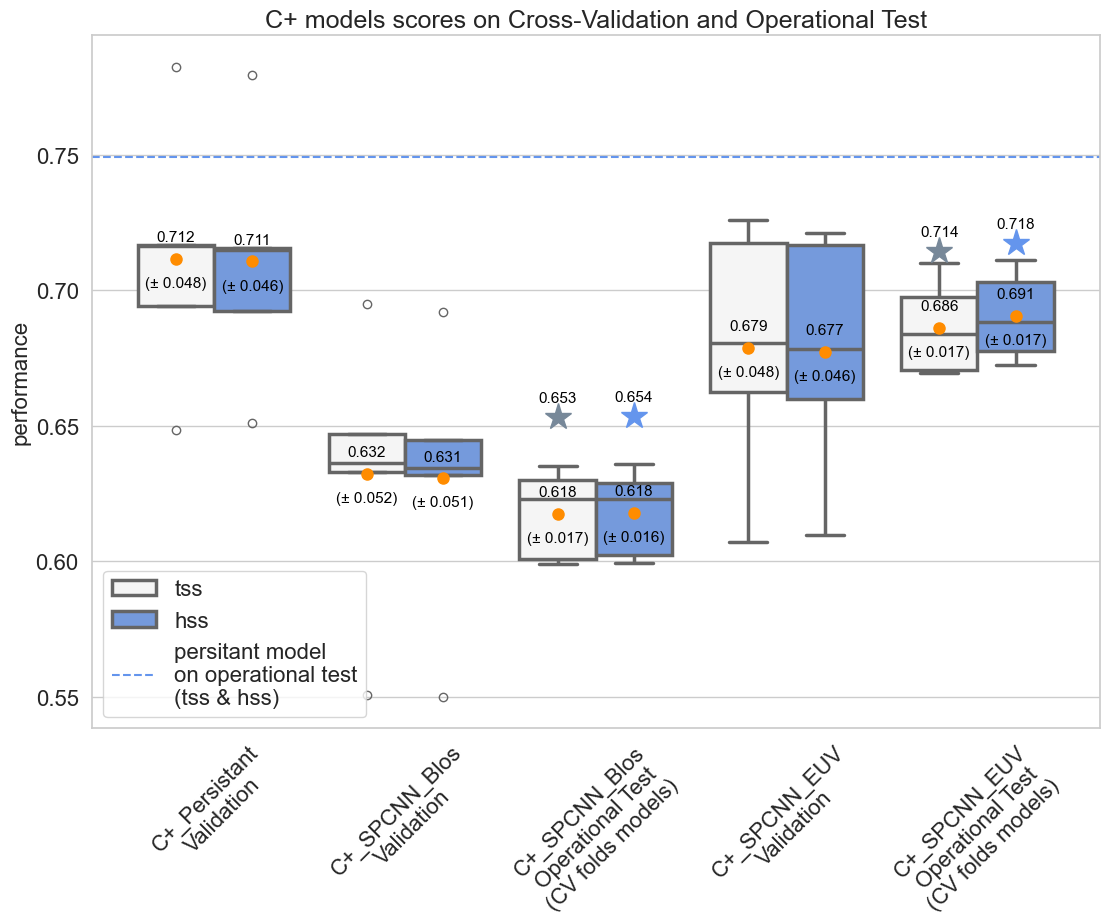

In [9]:
typeModel = 'C+'
metrics = ['tss','hss']
palette= ['whitesmoke','cornflowerblue']

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]


sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

color = 'silver' # 'lightblue' 'cornflowerblue'

box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            hue_order=metrics,
            dodge=True,
            linewidth=2.5,
            # palette= sns.color_palette([color]) ,#"Blues",#
            # color = 'cornflowerblue',
            palette= palette,
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    # mtc = metrics[idx % len(metrics)]
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.0065 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0.2
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.6,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.007
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'lightslategray'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = color)
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistant_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistant Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistant\nOperational Test\n(tss & hss)"]
labels = [metrics[0], metrics[1], "persitant model\non operational test\n(tss & hss)"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

### M+ -- TSS

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/3197300998.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/3197300998.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/3197300998.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

Text(0.5, 1.0, 'M+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


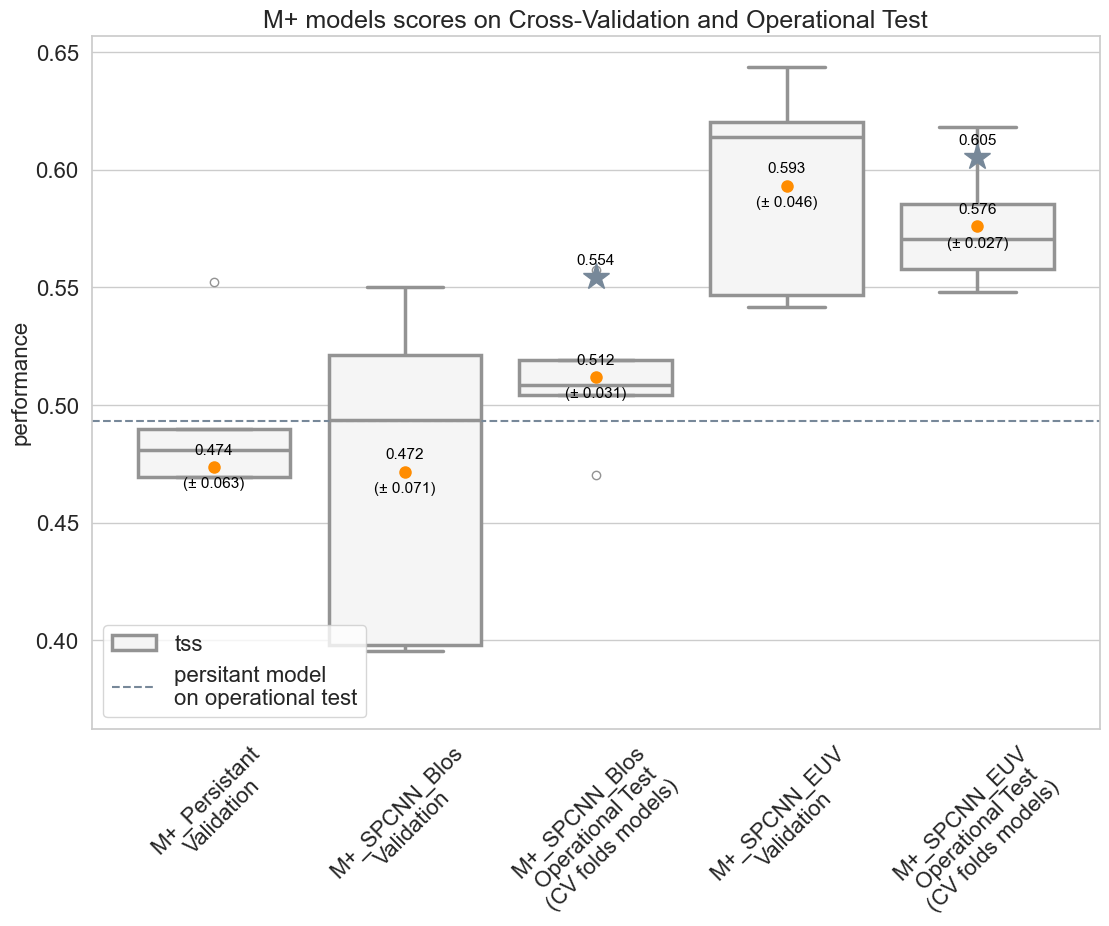

In [10]:
typeModel = 'M+'
metrics = ['tss']
palette = ['whitesmoke']

sns.set(style="whitegrid")

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

dfTemp = dfTemp[dfTemp['metric'].isin(metrics)]

color = 'silver' # 'lightblue' 'cornflowerblue'

box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            dodge=True,
            linewidth=2.5,
            palette= palette ,#"Blues",#
            # color = 'cornflowerblue',
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

# for patch in box_plot.artists:
#   patch.set_facecolor('cornflowerblue')


for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    # mtc = metrics[idx % len(metrics)]
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.0055 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.6,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.007
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'lightslategray'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = color)
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistant_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistant Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistant\nOperational Test\n(tss & hss)"]
labels = [metrics[0], "persitant model\non operational test"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

### M+ -- HSS

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/2889197045.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/2889197045.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_69226/2889197045.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

Text(0.5, 1.0, 'M+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


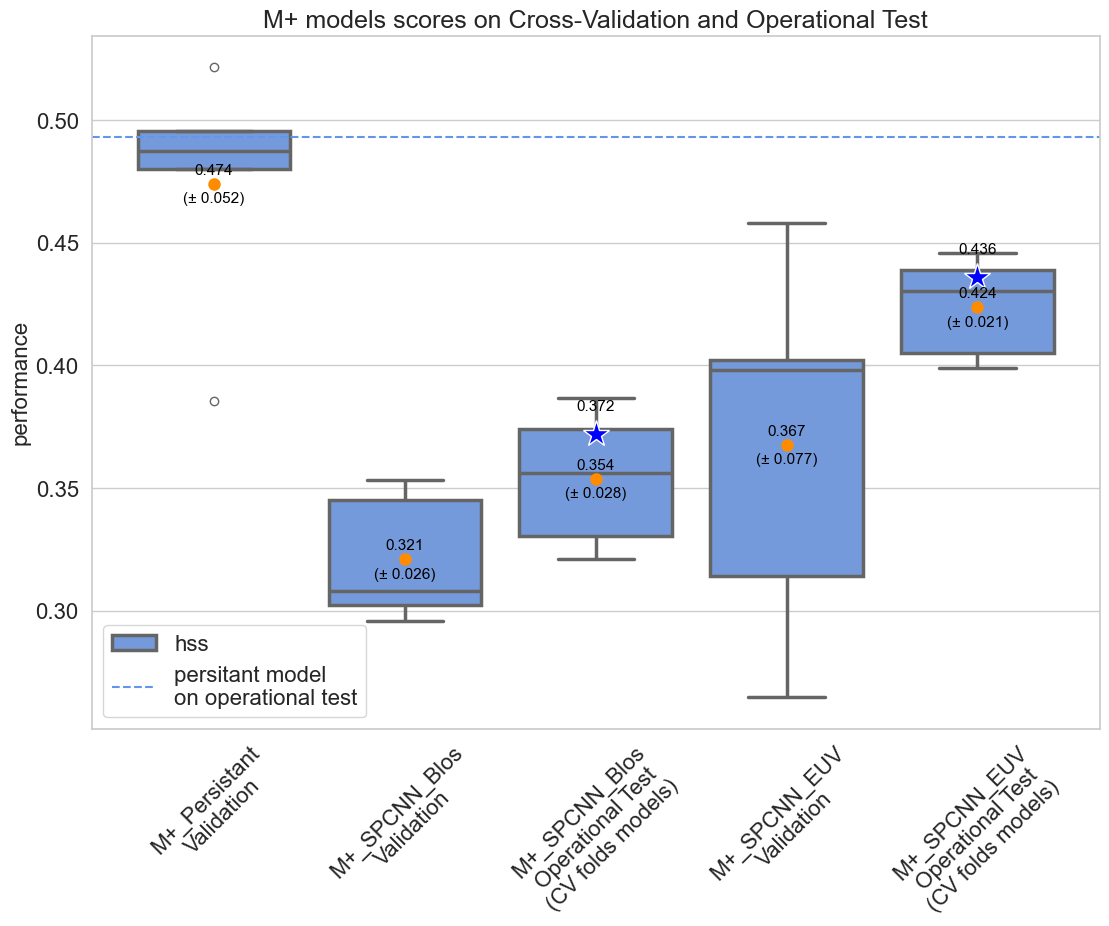

In [11]:
typeModel = 'M+'
metrics = ['hss']
palette = ['palette']
color = 'cornflowerblue' # 'lightblue' 'cornflowerblue'

sns.set(style="whitegrid")

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

dfTemp = dfTemp[dfTemp['metric'].isin(metrics)]


box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            dodge=True,
            linewidth=2.5,
            palette= sns.color_palette([color]) ,#"Blues",#
            # color = 'cornflowerblue',
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

# for patch in box_plot.artists:
#   patch.set_facecolor('cornflowerblue')


for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.004 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.9,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.0112
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'cornflowerblue'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = 'blue',markeredgecolor='white')
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistant_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistant Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistant\nOperational Test\n(tss & hss)"]
labels = [metrics[0], "persitant model\non operational test"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistant') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

# Pathes Performances

## Patches' Labels Computation

In [12]:
%%time
from sundl.utils.flare.windows import windowHistoryFromFlList_ByPatchSector_EXACT

CORRECTED_SECTOR = True
window_h         = 24
timeRes_h        = 2
num_patches      = 8
path_label_ptchs = F_PATH_LABEL_PATCHES(num_patches, timeRes_h, window_h)

# Take a few minutes (~5) if not already saved
if path_label_ptchs.exists():
  with open(path_label_ptchs, 'rb') as f1:
    fl_historys = pickle.load(f1)
else:
  # Loading flare catalog with position
  nan_val = 9999.0
  flCatalog_positions = read_Dataframe_With_Dates(PATH_FLCATALOG_WITH_POS, ['timestamp','tstart'])
  with open(PATH_MISSING_POS_DATES, 'rb') as f1:
    missing_positions_events = pickle.load(f1)
  print('MISSING DATES : ',len(missing_positions_events))
  remove_date = flCatalog_positions[(flCatalog_positions.x == nan_val) | (flCatalog_positions.y == nan_val)]
  # missing_positions_events = missing_positions_events.append(remove_date.reset_index()['timestamp']).reset_index(drop=True)
  missing_positions_events = pd.concat([missing_positions_events,remove_date.reset_index()['timestamp']])
  print('after nan rmvl: ',len(missing_positions_events))
  # Computing sector-windows-history/features
  fl_historys = windowHistoryFromFlList_ByPatchSector_EXACT(
      flCatalog_positions,
      missing_positions_events,
      window_h = window_h, 
      timeRes_h = timeRes_h,
      minDate = datetime.datetime(2020,1,1), 
      maxDate = None, 
      num_patches = num_patches)
  with open(path_label_ptchs, 'wb') as f1:
    pickle.dump(fl_historys, f1)


CPU times: user 3.35 ms, sys: 24.5 ms, total: 27.9 ms
Wall time: 139 ms


## Load Patches Predictions

In [13]:
%%time
from sundl.utils.flare.thresholds import mpfTresh, totehTresh

window_h   = 24
labelCol   = 'mpf'


modelsNames = [modelDictRev['C+_SPCNN_EUV'],
               modelDictRev['C+_SPCNN_Blos'],
               modelDictRev['M+_SPCNN_EUV'],
               modelDictRev['M+_SPCNN_Blos'],
               'C+_SPCNN_Both_Max',
               'M+_SPCNN_Both_Max',
               'C+_SPCNN_Both_Avg',
               'M+_SPCNN_Both_Avg'
               ]


# ensModIsMax = True
ensembles = {'C+_SPCNN_Both_Max'  : [modelDictRev['C+_SPCNN_EUV'], modelDictRev['C+_SPCNN_Blos']],
             'M+_SPCNN_Both_Max'  : [modelDictRev['M+_SPCNN_EUV'], modelDictRev['M+_SPCNN_Blos']],
             'C+_SPCNN_Both_Avg'  : [modelDictRev['C+_SPCNN_EUV'], modelDictRev['C+_SPCNN_Blos']],
             'M+_SPCNN_Both_Avg'  : [modelDictRev['M+_SPCNN_EUV'], modelDictRev['M+_SPCNN_Blos']]
            #  'C+_SPCNN_Histo' : [modelDictRev[c+_SPCNN_EUV'], modelDictRev['C+_SPCNN_Blos'] , modelDictRev['C+_Persistant']],
            #  'M+_SPCNN_Histo' : [modelDictRev['M+_SPCNN_EUV'], modelDictRev['M+_SPCNN_Blos'] , modelDictRev['M+_Persistant']]
             }

ensembles = {}
modelsNames = list(modelDict.keys())

ptPredictions = {}

if labelCol == 'mpf':
  classTresholds = mpfTresh
elif labelCol == 'toteh':
  classTresholds = totehTresh[h]

for modelName in modelsNames:
  # pathPredPt =  pathPreds/f'{modelName}_pt.csv'
  pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
  if pathPredPt_withLabels.exists():
    ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt_withLabels)
  else:
    pathPredPt = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', False)
    if modelName.split('_')[2]!='Persistant' and modelName.split('_')[0] in ['C+','M+']: # pathPredPt.exists() and # -->  pathPredPt must exists after notebook 3
      ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt)
      # ptPredictions[modelName]['timestamp'] = ptPredictions[modelName]['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) # '%Y/%m/%d/H%H00/
      # ptPredictions[modelName] = ptPredictions[modelName].set_index('timestamp',drop = True)
      if 'label' in ptPredictions[modelName].columns:
        ptPredictions[modelName] = ptPredictions[modelName].drop('label',axis=1)

      ptcPredCols = [col for col in ptPredictions[modelName].columns if len(col)==len('pred_pt0')]
      num_ptc = len(ptcPredCols)
      # fl_historys = windowHistoryFromFlList_ByPatchSector(window_h = window_h, timeRes_h = 2, minDate = datetime.datetime(2020,1,1), maxDate = maxDate, num_patches = num_ptc)

      for ptcId in range(num_ptc):
        histo = fl_historys[ptcId].copy()
        histo.index = histo.index + pd.DateOffset(hours= -window_h) # shifting history to window labels
        ptPredictions[modelName] = pd.concat([ptPredictions[modelName],
                                              histo[[labelCol]].rename(columns={labelCol:f'{labelCol}_pt{ptcId}'})
                                              ], axis=1, join="inner")
        cls = modelName[0]
        # @@@@@@@@@@@@ T
        ptPredictions[modelName][f'label_pt{ptcId}'] = ptPredictions[modelName][f'{labelCol}_pt{ptcId}'].apply(lambda x: x>=classTresholds[cls][0])

        ptPredictions[modelName][f'histo_pt{ptcId}'] = ptPredictions[modelName][f'label_pt{ptcId}'].rolling(window = f'{window_h}H',
                                          closed = 'right', # min_periods = int(input_lag)
                                          ).apply(
                                            lambda x: x[0])
        ptPredictions[modelName][f'change_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}'] != ptPredictions[modelName][f'label_pt{ptcId}']
        ptPredictions[modelName][f't2f_pt{ptcId}'] = histo['t2mpf_h']
        ptPredictions[modelName][f'x_pt{ptcId}'] = histo['x']
        ptPredictions[modelName][f'y_pt{ptcId}'] = histo['y']
      pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
      ptPredictions[modelName].to_csv(pathPredPt_withLabels)
    
# Creating persistant predictions at patch level
for idx,modelName in enumerate([f'C+_{labelCol}_Persistant_{window_h}',f'M+_{labelCol}_Persistant_{window_h}']):
  pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
  if pathPredPt_withLabels.exists():
    ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt_withLabels)
  else:
    cls = modelName[:2]
    tmp = ptPredictions[modelDictRev[f'{cls}_SPCNN_EUV']].copy()
    ptcPredCols = [col for col in tmp.columns if len(col)==len('pred_pt0')]
    num_ptc = len(ptcPredCols)
    ptPredictions[modelName] = tmp[[col for col in tmp.columns if col[:3]!='pre']]
    # ptPredictions[modelName] = ptPredictions[modelName][[col for col in ptPredictions[modelName].columns if col[:3]!='lab']]
    for ptcId in range(num_ptc):
      ptPredictions[modelName][f'pred_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}']
      # ptPredictions[modelName][f'label_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}']
  # ptPredictions[list(ptPredictions.keys())[0]]
    pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
    ptPredictions[modelName].to_csv(pathPredPt_withLabels)



# modelsNames = modelsNames + list(ensembles.keys())

CPU times: user 2.63 s, sys: 486 ms, total: 3.12 s
Wall time: 3.29 s


## Compute Peformances

In [14]:
from notebooks.flare_limits_pcnn.utilsTest import patchesPerformance

startingDates = [datetime.datetime(2020,1,1)]
filterNames   = ['all','windowChanging', 'windowConstant']
includeFolds  = True

perfTestPtTot, perfTestByPatch = patchesPerformance(
    ptPredictions, 
    startingDates, 
    filterNames, 
    includeFolds)

/Users/greg/Projects/sundl/notebooks/flare_limits_pcnn/../../notebooks/flare_limits_pcnn/utilsTest.py:259: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTestByPatch = pd.concat([perfTestByPatch,pd.DataFrame({'model':modelName,
/Users/greg/Projects/sundl/notebooks/flare_limits_pcnn/../../notebooks/flare_limits_pcnn/utilsTest.py:324: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTestPtTot = pd.concat([perfTestPtTot,pd.DataFrame({'model':modelName,
/Users/greg/Projects/sundl/notebooks/flare

### Standard Metrics

In [15]:
group = 'all' # @['all', 'limb', 'center']

viz = perfTestPtTot.copy()[(perfTestPtTot.modelFdId == 'avg') & (perfTestPtTot.group == group)]
viz = viz[viz['startingDate']==viz['startingDate'].min()]

col = ['model', 'filter','tss', 'hss', 'f1', # 'modelFdId', 'group', 'thd'
       'recall', 'far', 'mcc', 'acc_w', 'fssp', 'fssr', 'bal_pos', 'switch_rate'
]
viz[viz['filter']=='all'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
1,C+_mpf_Persistant_24,all,0.596934,0.596922,0.668598,0.668615,0.331419,0.592464,0.798467,0.000025,0.550740,0.177816,0.117860
79,C+_SPCNN_Both_Max,all,0.529527,0.574706,0.644819,0.579121,0.272669,0.622864,0.764763,-0.035839,0.512724,0.185954,0.123180
112,C+_SPCNN_Both_Avg,all,0.442511,0.528400,0.592690,0.467829,0.191536,0.603036,0.721256,-0.113784,0.441209,0.185954,0.123180
22,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,all,0.444310,0.527183,0.590163,0.471788,0.212165,0.601170,0.722155,-0.117301,0.444411,0.177816,0.117860
4,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,all,0.401951,0.479973,0.550871,0.434807,0.248539,0.558054,0.700975,-0.175752,0.383813,0.185980,0.123367
40,M+_mpf_Persistant_24,all,0.380748,0.373512,0.385531,0.393146,0.621795,0.458683,0.690374,0.019370,0.362401,0.018821,0.023586
61,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,all,0.477326,0.287003,0.305836,0.512613,0.782072,0.349573,0.738663,-0.180930,0.279706,0.018821,0.023586
127,M+_SPCNN_Both_Avg,all,0.477620,0.274820,0.295287,0.517670,0.793445,0.340637,0.738810,-0.210808,0.267461,0.019743,0.024711
94,M+_SPCNN_Both_Max,all,0.543544,0.232429,0.256333,0.606495,0.837492,0.335599,0.771772,-0.314920,0.226968,0.019743,0.024711
43,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,all,0.350346,0.198891,0.221658,0.393925,0.845782,0.262501,0.675173,-0.409565,0.190878,0.019773,0.024700


### AC - metrics

In [16]:
viz[viz['filter']=='windowChanging'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
223,C+_SPCNN_Both_Max,windowChanging,0.028889,0.028888,0.377429,0.294352,0.474159,-0.031533,0.514445,0.377381,-0.245171,0.500038,1.0
166,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowChanging,0.028606,0.028607,0.288577,0.197020,0.460899,-0.049900,0.514303,0.288631,-0.422824,0.499962,1.0
187,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,windowChanging,0.026708,0.026927,0.423444,0.365204,0.496216,0.205184,0.513354,0.440968,-0.139838,0.484802,1.0
256,C+_SPCNN_Both_Avg,windowChanging,0.016047,0.016046,0.269379,0.181387,0.476821,-0.031011,0.508023,0.269323,-0.461262,0.500038,1.0
148,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,windowChanging,0.010668,0.010671,0.279188,0.191629,0.485913,-0.024024,0.505334,0.279517,-0.441496,0.499772,1.0
271,M+_SPCNN_Both_Avg,windowChanging,-0.004941,-0.004959,0.451694,0.425532,0.518717,0.152409,0.497529,0.469057,-0.081841,0.484166,1.0
205,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowChanging,-0.018951,-0.019039,0.433786,0.400784,0.527290,0.108730,0.490525,0.451635,-0.118309,0.484239,1.0
238,M+_SPCNN_Both_Max,windowChanging,-0.029462,-0.029366,0.494012,0.520095,0.529579,0.151390,0.485269,0.510035,0.004047,0.484166,1.0
184,M+_mpf_Persistant_24,windowChanging,-1.000000,-0.998015,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.484239,1.0
145,C+_mpf_Persistant_24,windowChanging,-1.000000,-1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.499962,1.0


### NC - meetrics

In [17]:
viz[viz['filter']=='windowConstant'].sort_values(['hss'], ascending = False)[col]

,model,filter,tss,hss,f1,recall,far,mcc,acc_w,fssp,fssr,bal_pos,switch_rate
289,C+_mpf_Persistant_24,windowConstant,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.134775,0.0
328,M+_mpf_Persistant_24,windowConstant,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.007578,0.0
367,C+_SPCNN_Both_Max,windowConstant,0.688241,0.714067,0.752784,0.720167,0.211505,0.774364,0.844120,-0.247216,0.682658,0.141829,0.0
400,C+_SPCNN_Both_Avg,windowConstant,0.595846,0.683231,0.720029,0.609704,0.120901,0.768814,0.797923,-0.279971,0.640612,0.141829,0.0
310,C+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowConstant,0.591376,0.672407,0.709207,0.607972,0.149109,0.759749,0.795688,-0.290793,0.630823,0.134775,0.0
292,C+_mpf_PTx8_RtdXall_ProgPos_AW4e6D4e3_blos_24,windowConstant,0.534698,0.616909,0.660918,0.555405,0.184076,0.706732,0.767349,-0.339082,0.564741,0.141820,0.0
349,M+_mpf_PTx8_RtdXall_ProgPos_AW1e5D1e4_0193x021...,windowConstant,0.654770,0.231930,0.241519,0.685230,0.853406,0.322709,0.827385,-0.758481,0.230023,0.007578,0.0
415,M+_SPCNN_Both_Avg,windowConstant,0.624488,0.209242,0.219754,0.659394,0.868153,0.298276,0.812244,-0.780246,0.207308,0.007975,0.0
382,M+_SPCNN_Both_Max,windowConstant,0.682854,0.156660,0.168578,0.739394,0.904866,0.276137,0.841427,-0.831422,0.155316,0.007975,0.0
331,M+_mpf_PTx8_RtdXall_LowC_AW6e6D1e3_blos_24,windowConstant,0.398326,0.125888,0.137670,0.438026,0.918331,0.172636,0.699163,-0.862330,0.123880,0.007996,0.0
